## Regression Discontinuity (RD)


Regression Discontinuity analysis  can be used to analyze data from Natural Experiments in which some kind of cutoff determines who goes into one group versus another. It is important that subjects cannot choose on which side of the cutoff the end up. Therefore, no self-selection bias is present and the assignment of subjects is "as-if-random".

Instead of looking at the effect of the predictor on the outcome for the entire population, we compare predicted outcomes of subjects near the cutoff. Since it is unclear what near the cutoff means, we need to try different bandwidths and compare results.

RD regresses the outcome on two predictors: a coarsened assignment variables and the dummy coded assignment variable (treated or not treated). Again, how much we coarsen the assignment variable may have an impact on the results and therefore we need to try different levels of coarsening.

### Example
- Loyola Law School (LLS) wanted to help struggling students perform better in their second year 
- Those with first-semester GPAs below 2.75 were required to take an additional course in Spring designed to build skills 
- All students with low GPAs were required to take the course, and no students with higher GPAs were allowed 
- The outcome was GPA in Fall of their second year


Source: Cannot find the source anymore... :( Found the example somewhere online. 
Data: https://drive.google.com/file/d/0B0BUhVJfHkISVjhDNXQ1SXNQWmc/view


### Data
- 'intervention' is a binary variable which is 1 if the GPA of students was below 2.75 and 0 otherwise
- 'pregpa' is the variable on which we define the threshold
- 'postgpa_a' and 'postgpa_b' are the outcome variables


### Research Question:
Did the additional course help the students to improve their skills?



In [63]:
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
# TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
# IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
# WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
# SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

%pylab inline

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting

import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy


df = pd.read_csv("./sampledata.csv")

df["gpa_change"] = df["postgpa_b"] - df["postgpa_a"]
print (df.head())

print ("==============================================================================")
print ("                              OVERALL SUMMARY" )
print ("==============================================================================")
print (df.describe())

Populating the interactive namespace from numpy and matplotlib
    sid    pregpa  intervention  postgpa_a  postgpa_b  gpa_change
0  1001  3.155467             0         87         87           0
1  1002  3.000000             0         77         77           0
2  1003  2.420000             1         78         79           1
3  1004  2.533533             1         78         78           0
4  1005  2.422267             1         79         80           1
                              OVERALL SUMMARY
               sid      pregpa  intervention   postgpa_a   postgpa_b  \
count   218.000000  218.000000    218.000000  218.000000  218.000000   
mean   1146.729358    3.153694      0.206422   82.715596   82.912844   
std      86.068642    0.470539      0.405668    6.045285    4.927747   
min    1001.000000    1.977733      0.000000   62.000000   75.000000   
25%    1071.500000    2.866533      0.000000   78.000000   79.000000   
50%    1153.500000    3.155567      0.000000   82.000000   82.0

#### Explore the potential effect of the intervention

First we simply compare the 2 groups. Did people who took the additional course perform worse? 

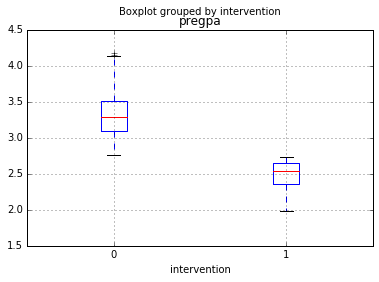

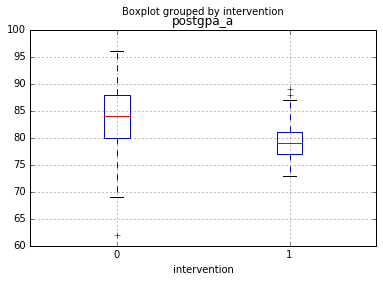

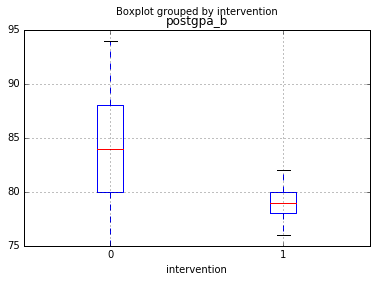

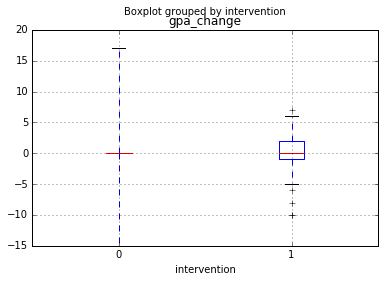

In [64]:
df.boxplot("pregpa", "intervention")
plt.show()

df.boxplot("postgpa_a", "intervention")
plt.show()

df.boxplot("postgpa_b", "intervention")
plt.show()


df.boxplot("gpa_change", "intervention")
plt.show()

There is a clear relation between performance and beeing selected. Students in the treatment group probably have lower abilities and therefore will also perform worse in the post test. However we can compare the performance change of people in the treatment and control group (gpy_change). Here we see that the median increase was higher for people in the treatment group.  

However, also when looking at the performance increase ability and interest may act as confounding variables. Students who have higher abilities may improve and learn faster than those with lower abilities.

Solution: Let's only compare those people who were closed to the threshold. These students are very similar and only the "luck factor" differentiated them.

### Regression Discontinuity Analysis

We only want to compare people near the threshold (aka cutoff). So we conduct the following steps:

1) Transform the pre-treatment value (x). Subtract cutoff score from pre-treatment score
2) Dummy code the assignment variable. 0 means no treatment, 1 means treatment.
3) Use dummy coded assigment variable and coarsened independent variable to model the outcome variable
4) Check if relatioship between indpedent variable and outcome variable is linear. Does adding high order polynomial terms change the results? (robustness check)
5) Pick random points as thresholds (placebo points). Do we also observe a discontinuity there?


      sid    pregpa  intervention  postgpa_a  postgpa_b  gpa_change  \
160  1215  2.000000             1         75         77           2   
195  1262  1.977733             1         76         77           1   
132  1181  2.088800             1         73         80           7   
148  1201  2.133133             1         75         81           6   
33   1041  2.111067             1         76         80           4   

     pregpa_trans  pregpa_trans_round  
160     -0.750000                -0.8  
195     -0.772267                -0.8  
132     -0.661200                -0.7  
148     -0.616867                -0.6  
33      -0.638933                -0.6  


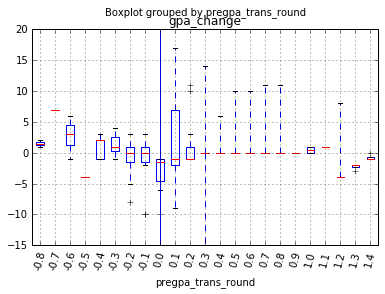

In [70]:
bandwidth_min = 2.5 #2.55
bandwidth_max =  2.9 #2.95
cutoff = 2.75


#df[(df['pregpa'] >= bandwidth_min) & (df['pregpa'] <= bandwidth_max)].boxplot("postgpa_a", "intervention")
#plt.show()


# Step 1: Transform the pre-treatment value
df["pregpa_trans"] = df["pregpa"] - cutoff


# Coarsen it, since this will be our independent variable
df["pregpa_trans_round"] =  np.round(df.pregpa_trans.values, 1)



print(df.head())

df.boxplot("gpa_change", "pregpa_trans_round", rot=75)
plt.axvline(x=9,color="blue", linestyle="-")
plt.show()


# Step 2: dummy var exists already and is called "intervention"
# however we could also create it easily
# df["intervention_test"] = df["pregpa"] < cutoff


We want to compare students that were unlucky and not selected (e.g., 0, 0.1) with those who were selected (-0.1, -0.2).



In [77]:
#Step 3: Model outcome variable as linear combination of dummy coded assignment var and corased assignment var


result = smf.ols(formula = "gpa_change ~ pregpa_trans_round + intervention + pregpa_trans_round*intervention", 
                 data = df).fit()
print (result.summary())



print ("\n \n treatment group only")
result_treated = smf.ols(formula = "gpa_change ~ pregpa_trans_round", 
                 data = df[df.pregpa_trans_round < 0]).fit()
print (result_treated.summary())


print ("\n \n control group only")
result_control = smf.ols(formula = "gpa_change ~ pregpa_trans_round", 
                 data = df[df.pregpa_trans_round >= 0]).fit()
print (result_control.summary())



                            OLS Regression Results                            
Dep. Variable:             gpa_change   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.276
Date:                Wed, 09 Mar 2016   Prob (F-statistic):            0.00588
Time:                        08:53:35   Log-Likelihood:                -573.11
No. Observations:                 218   AIC:                             1154.
Df Residuals:                     214   BIC:                             1168.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept 

From the first model (full model) one can see that the intervention has a significant impact on the outcome also if we control for the coarsened assignment variable. The main effect of the intervention is significant (i.e., there is a jump in the cutoff). There is also a significant interaction effect which indicates that the slope of the line changes in the cutoff.


In the control group the assignment variable has no effect. In the treatment group there is a significant negative effect of the pregpa on the performance increase. That means that only students who were worse benefited most from the additional course.

41


C:\Users\wagnerca\AppData\Local\Continuum\Miniconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


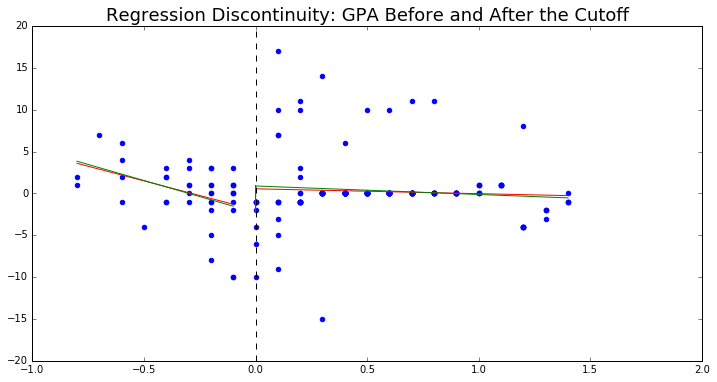

In [80]:
# Visualize results

df.sort(columns =['pregpa_trans_round'], axis=0, inplace=True)
df_control = df[df.pregpa_trans_round >= 0]
df_treated = df[df.pregpa_trans_round < 0]


plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df['pregpa_trans_round'], df['gpa_change'], color="blue")


l=np.size(df[df.pregpa_trans_round < 0].pregpa_trans_round)
print (l)



plt.plot(df_treated.pregpa_trans_round, result_treated.predict(), '-', color="r") #df.pregpa_trans_round[:l]
plt.plot(df_control.pregpa_trans_round, result_control.predict(), '-', color="r")

plt.plot(df.pregpa_trans_round[:l], result.predict()[:l], '-', color="g")
plt.plot(df.pregpa_trans_round[l:], result.predict()[l:], '-', color="g")

plt.axvline(x=0,color="black", linestyle="--")
plt.title("Regression Discontinuity: GPA Before and After the Cutoff", fontsize="18")

In [81]:
# Step 4: is relationship is linear? Visualize it
# compare R2 of linear model with model that adds higher order polynomials
# do the effects change?

result_nonlin = smf.ols(formula = "gpa_change ~  np.power(pregpa_trans_round, 2)  + intervention + np.power(pregpa_trans_round, 2)*intervention", 
                 data = df).fit()
print (result_nonlin.summary())

                            OLS Regression Results                            
Dep. Variable:             gpa_change   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.850
Date:                Wed, 09 Mar 2016   Prob (F-statistic):             0.0103
Time:                        08:55:43   Log-Likelihood:                -573.72
No. Observations:                 218   AIC:                             1155.
Df Residuals:                     214   BIC:                             1169.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------

The fit of the model does not improve by adding higher order polynomial terms